<a href="https://colab.research.google.com/github/muhamadghibran/-Analisis-Clustering-Wilayah-Rawan-Bencana-Alam/blob/main/Google%20Collabs_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist

In [ ]:
sns.set(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 6)

print("=== ANALISIS PENGELOMPOKAN WILAYAH RAWAN BENCANA DI INDONESIA ===")
print("Menggunakan Metode Hierarchical Clustering\n")

=== ANALISIS PENGELOMPOKAN WILAYAH RAWAN BENCANA DI INDONESIA ===
Menggunakan Metode Hierarchical Clustering



In [ ]:
try:
    data = pd.read_csv('Penyebaran Bencana Alam di Indonesia.csv')
    print(f"Data berhasil dimuat: {data.shape[0]} baris, {data.shape[1]} kolom")
    print(f"Kolom dalam dataset: {list(data.columns)}")
except FileNotFoundError:
    print("File dataset tidak ditemukan. Pastikan file 'Penyebaran Bencana Alam di Indonesia.csv' ada di direktori yang sama.")
    print("Atau upload file ke Google Colab terlebih dahulu.")
    raise

Data berhasil dimuat: 4235 baris, 22 kolom
Kolom dalam dataset: ['pkey', 'date', 'time', 'source', 'status', 'url', 'image_url', 'disaster_type', 'report_dat', 'tags', 'title', 'text', 'ID_Desa', 'ID_Kec', 'ID_Kab', 'ID_Prov', 'Desa', 'Kecamatan', 'Kabupaten', 'Provinsi', 'long', 'lat']


In [ ]:
print("\n--- EKSPLORASI DATA AWAL ---")
print("5 baris pertama data:")
print(data.head())

print(f"\nInfo dataset:")
print(f"- Jumlah baris: {len(data)}")
print(f"- Jumlah kolom: {len(data.columns)}")
print(f"- Missing values per kolom:")
print(data.isnull().sum())

print(f"\nTipe data setiap kolom:")
print(data.dtypes)


--- EKSPLORASI DATA AWAL ---
5 baris pertama data:
    pkey        date      time source     status  \
0  94941  01/01/2020  00:03:02  grasp  confirmed   
1  95061  01/01/2020  00:43:02  grasp  confirmed   
2  95062  01/01/2020  01:14:53  grasp  confirmed   
3  95063  01/01/2020  01:15:08  grasp  confirmed   
4  95064  01/01/2020  01:18:03  grasp  confirmed   

                                    url  \
0  2042596d-b551-4ef2-803d-1ee964cf2278   
1  5a0ad45f-7020-43b7-882f-672487ebc6d8   
2  e065b40d-2084-48d6-b42f-1f98cb33e4cc   
3  7cb26903-b1c8-4be7-8b81-7014c8a83fbd   
4  570d2cb8-d5b6-404f-86ef-8a2a0d27f391   

                                           image_url disaster_type  \
0  https://images.petabencana.id/2042596d-b551-4e...         flood   
1  https://images.petabencana.id/5a0ad45f-7020-43...         flood   
2                                                NaN         flood   
3  https://images.petabencana.id/7cb26903-b1c8-4b...         flood   
4  https://images.petabenc

In [ ]:
kolom_bencana = []
for col in data.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['banjir', 'longsor', 'gempa', 'tsunami',
                                               'gelombang', 'angin', 'gunung', 'kebakaran',
                                               'kekeringan', 'abrasi', 'puyuh', 'puting',
                                               'tanah', 'api', 'erupsi', 'letusan']):
        kolom_bencana.append(col)

print(f"\nKolom bencana yang teridentifikasi: {kolom_bencana}")

if not kolom_bencana:
    kolom_numerik = data.select_dtypes(include=[np.number]).columns.tolist()
    kolom_numerik = [col for col in kolom_numerik if not any(keyword in col.lower()
                     for keyword in ['lat', 'lon', 'koordinat', 'latitude', 'longitude'])]
    kolom_bencana = kolom_numerik
    print(f"Menggunakan semua kolom numerik: {kolom_bencana}")

if not kolom_bencana:
    print("Tidak ditemukan kolom numerik untuk clustering.")
    print("Silakan periksa struktur dataset:")
    print(data.info())
    raise ValueError("Tidak ada kolom numerik yang sesuai untuk clustering")


Kolom bencana yang teridentifikasi: []
Menggunakan semua kolom numerik: ['pkey', 'ID_Desa', 'ID_Kec', 'ID_Kab', 'ID_Prov']


In [ ]:
kolom_wilayah = None
for col in data.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in ['kabupaten', 'kota', 'wilayah', 'daerah', 'provinsi', 'kecamatan']):
        kolom_wilayah = col
        break
if kolom_wilayah is None:
    kolom_string = data.select_dtypes(include=['object']).columns
    if len(kolom_string) > 0:
        kolom_wilayah = kolom_string[0]

print(f"Kolom wilayah: {kolom_wilayah}")

Kolom wilayah: Kecamatan


In [ ]:
if kolom_wilayah and kolom_bencana:
    print(f"\nMissing values dalam kolom bencana:")
    missing_bencana = data[kolom_bencana].isnull().sum()
    print(missing_bencana[missing_bencana > 0])

    data_agregat = (
        data
        .groupby(kolom_wilayah)[kolom_bencana]
        .sum()
        .fillna(0)
    )
    print(f"\n--- DATA SETELAH AGREGASI ---")
    print(f"Jumlah wilayah: {len(data_agregat)}")
    print(f"Jumlah variabel bencana: {len(kolom_bencana)}")

    print("\nStatistik deskriptif data bencana:")
    print(data_agregat.describe())

else:
    print("Tidak dapat mengidentifikasi kolom wilayah atau kolom bencana.")
    print("Silakan periksa struktur dataset dan sesuaikan kode secara manual.")
    raise ValueError("Kolom wilayah atau bencana tidak teridentifikasi")


Missing values dalam kolom bencana:
ID_Desa    8
ID_Kec     8
ID_Kab     8
ID_Prov    8
dtype: int64

--- DATA SETELAH AGREGASI ---
Jumlah wilayah: 667
Jumlah variabel bencana: 5

Statistik deskriptif data bencana:
               pkey       ID_Desa        ID_Kec         ID_Kab      ID_Prov
count  6.670000e+02  6.670000e+02  6.670000e+02     667.000000   667.000000
mean   1.162484e+06  2.257031e+10  2.257031e+07   22569.928036   221.970015
std    2.650559e+06  5.296969e+10  5.296969e+07   52968.880008   517.898539
min    9.614500e+04  1.104053e+09  1.104053e+06    1104.000000    11.000000
25%    2.263685e+05  3.309065e+09  3.309065e+06    3309.000000    33.000000
50%    2.990560e+05  6.410040e+09  6.410040e+06    6410.000000    64.000000
75%    6.882280e+05  1.310614e+10  1.310614e+07   13106.000000   128.000000
max    2.711097e+07  4.792770e+11  4.792770e+08  479274.000000  4681.000000


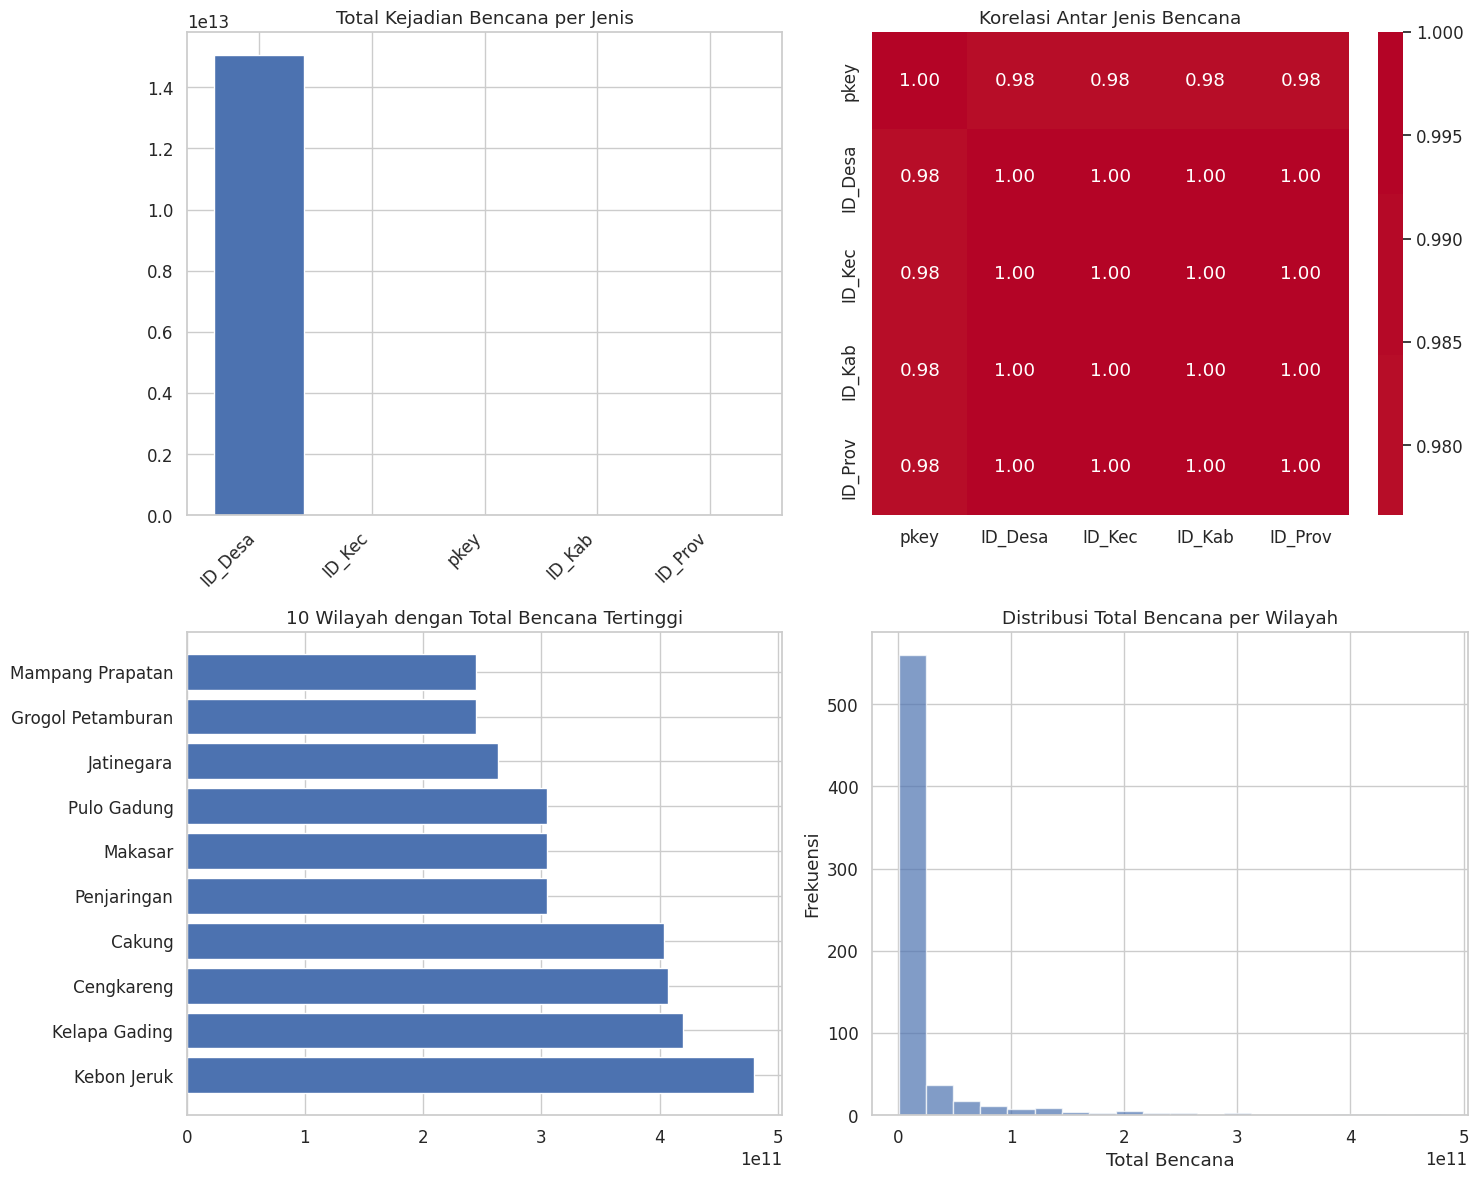

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

data_sum = data_agregat.sum().sort_values(ascending=False)
axes[0, 0].bar(range(len(data_sum)), data_sum.values)
axes[0, 0].set_title('Total Kejadian Bencana per Jenis')
axes[0, 0].set_xticks(range(len(data_sum)))
axes[0, 0].set_xticklabels(data_sum.index, rotation=45, ha='right')

if len(kolom_bencana) > 1:
    correlation_matrix = data_agregat.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=axes[0, 1])
    axes[0, 1].set_title('Korelasi Antar Jenis Bencana')
else:
    axes[0, 1].text(0.5, 0.5, 'Hanya 1 kolom bencana\nTidak dapat menghitung korelasi',
                    ha='center', va='center', transform=axes[0, 1].transAxes)

total_bencana_per_wilayah = data_agregat.sum(axis=1).sort_values(ascending=False).head(10)
axes[1, 0].barh(range(len(total_bencana_per_wilayah)), total_bencana_per_wilayah.values)
axes[1, 0].set_title('10 Wilayah dengan Total Bencana Tertinggi')
axes[1, 0].set_yticks(range(len(total_bencana_per_wilayah)))
axes[1, 0].set_yticklabels(total_bencana_per_wilayah.index)

total_per_wilayah = data_agregat.sum(axis=1)
axes[1, 1].hist(total_per_wilayah, bins=20, alpha=0.7)
axes[1, 1].set_title('Distribusi Total Bencana per Wilayah')
axes[1, 1].set_xlabel('Total Bencana')
axes[1, 1].set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [ ]:
scaler = StandardScaler()
data_standar = scaler.fit_transform(data_agregat)

print(f"\n--- STANDARISASI DATA ---")
print(f"Data telah distandarisasi dengan StandardScaler")
print(f"Shape data: {data_standar.shape}")


--- STANDARISASI DATA ---
Data telah distandarisasi dengan StandardScaler
Shape data: (667, 5)


In [ ]:
print(f"\n--- EVALUASI METODE CLUSTERING ---")
metode_linkage = ['single', 'complete', 'average', 'ward']
hasil_evaluasi = []

for metode in metode_linkage:
    try:
        Z = linkage(data_standar, method=metode, metric='euclidean')

        max_clusters = min(8, len(data_standar) - 1)
        for k in range(2, max_clusters):
            label_cluster = fcluster(Z, t=k, criterion='maxclust')

            unique_clusters = len(np.unique(label_cluster))
            if unique_clusters > 1:
                sil_score = silhouette_score(data_standar, label_cluster)
                db_score = davies_bouldin_score(data_standar, label_cluster)
                coph_corr, _ = cophenet(Z, pdist(data_standar))

                hasil_evaluasi.append({
                    'Metode': metode,
                    'Jumlah_Cluster': k,
                    'Silhouette_Score': sil_score,
                    'Davies_Bouldin_Score': db_score,
                    'Cophenetic_Correlation': coph_corr
                })

    except Exception as e:
        print(f"Error pada metode {metode}: {e}")

if hasil_evaluasi:
    hasil_df = pd.DataFrame(hasil_evaluasi)
    print("\nHasil Evaluasi Clustering:")
    print(hasil_df.round(4))


--- EVALUASI METODE CLUSTERING ---

Hasil Evaluasi Clustering:
      Metode  Jumlah_Cluster  Silhouette_Score  Davies_Bouldin_Score  \
0     single               2            0.9124                0.1706   
1     single               3            0.9038                0.2156   
2     single               4            0.8492                0.2046   
3     single               5            0.8594                0.2993   
4     single               6            0.8581                0.2700   
5     single               7            0.8573                0.1773   
6   complete               2            0.9124                0.1706   
7   complete               3            0.8867                0.3699   
8   complete               4            0.8482                0.4444   
9   complete               5            0.8476                0.5194   
10  complete               6            0.8470                0.4642   
11  complete               7            0.8067                0.4924   


In [ ]:
    terbaik = hasil_df.loc[hasil_df['Silhouette_Score'].idxmax()]
    print(f"\nKONFIGURASI TERBAIK:")
    print(f"  - Metode: {terbaik['Metode']}")
    print(f"  - Jumlah Cluster: {int(terbaik['Jumlah_Cluster'])}")
    print(f"  - Silhouette Score: {terbaik['Silhouette_Score']:.4f}")
    print(f"  - Davies-Bouldin Score: {terbaik['Davies_Bouldin_Score']:.4f}")


KONFIGURASI TERBAIK:
  - Metode: single
  - Jumlah Cluster: 2
  - Silhouette Score: 0.9124
  - Davies-Bouldin Score: 0.1706


In [ ]:
    metode_terbaik = terbaik['Metode']
    k_terbaik = int(terbaik['Jumlah_Cluster'])

    Z_final = linkage(data_standar, method=metode_terbaik, metric='euclidean')
    label_final = fcluster(Z_final, t=k_terbaik, criterion='maxclust')

    data_hasil = data_agregat.copy()
    data_hasil['Cluster'] = label_final

    print(f"\n--- HASIL CLUSTERING FINAL ---")
    print(f"Distribusi wilayah per cluster:")
    cluster_counts = pd.Series(label_final).value_counts().sort_index()
    for i, count in cluster_counts.items():
        print(f"Cluster {i}: {count} wilayah")


--- HASIL CLUSTERING FINAL ---
Distribusi wilayah per cluster:
Cluster 1: 663 wilayah
Cluster 2: 4 wilayah


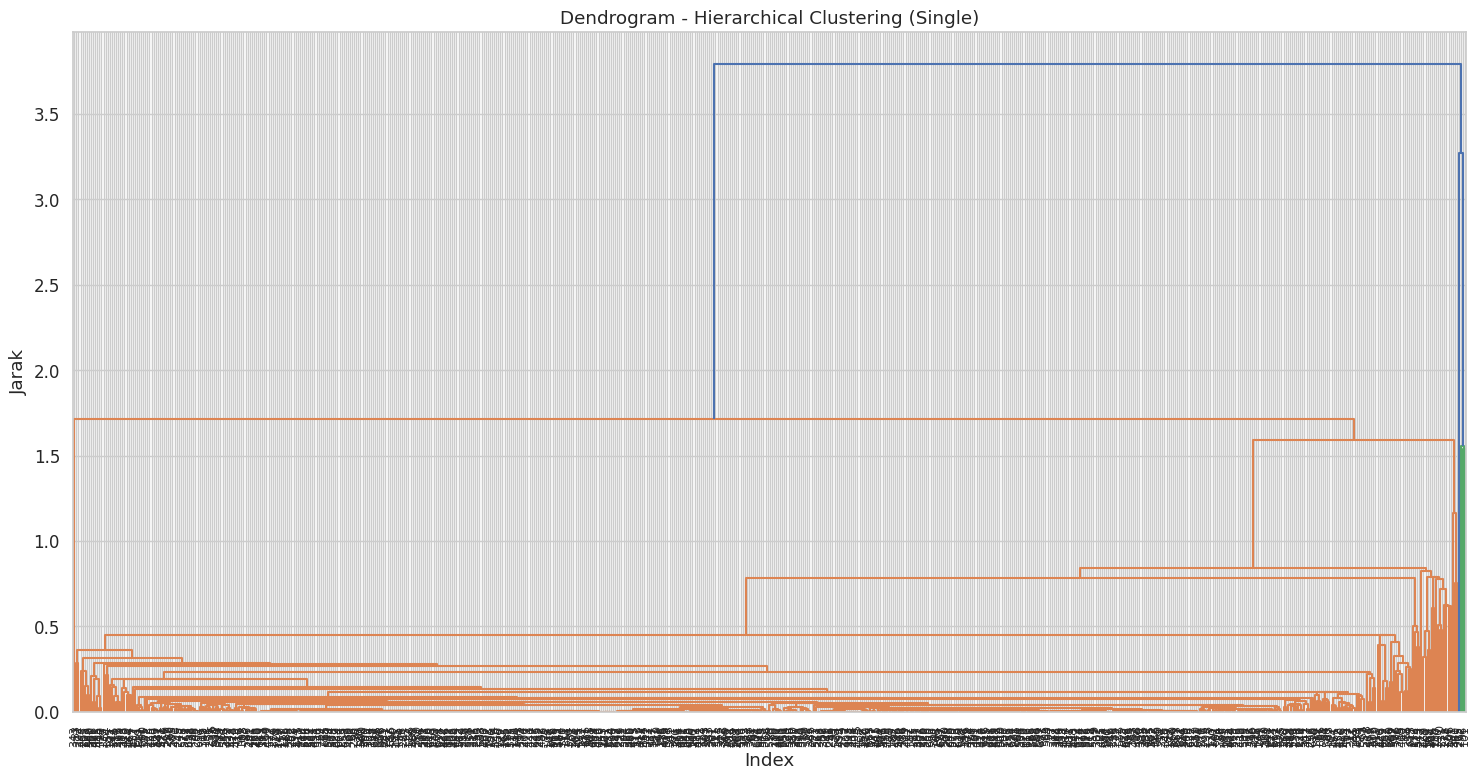

In [ ]:
    plt.figure(figsize=(15, 8))
    if len(data_agregat) <= 50:
        labels = data_agregat.index.tolist()
    else:
        labels = None

    dendrogram(
        Z_final,
        labels=labels,
        leaf_rotation=90,
        leaf_font_size=8,
        color_threshold=0.7 * max(Z_final[:, 2])
    )
    plt.title(f'Dendrogram - Hierarchical Clustering ({metode_terbaik.title()})')
    plt.xlabel('Wilayah' if labels else 'Index')
    plt.ylabel('Jarak')
    plt.tight_layout()
    plt.show()

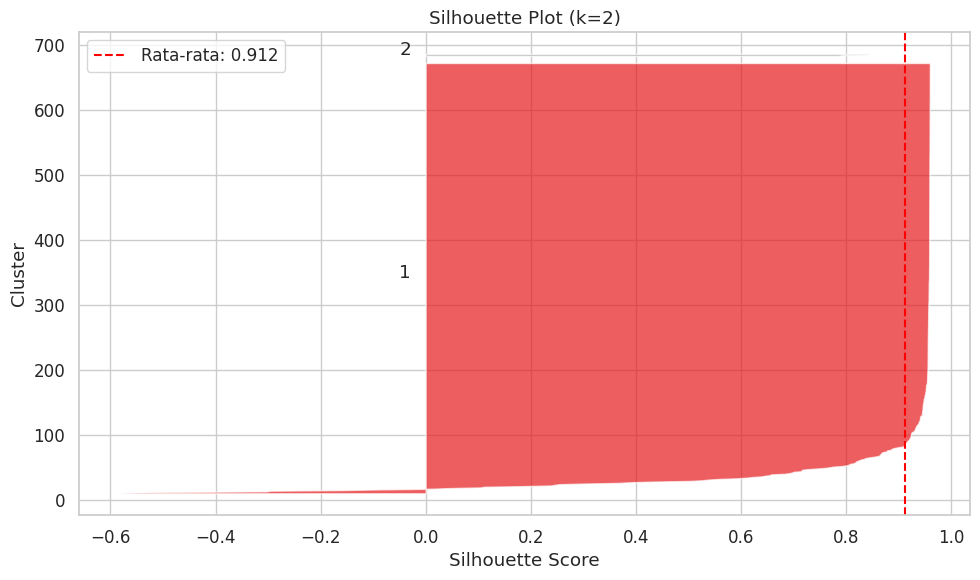

In [ ]:
    sil_values = silhouette_samples(data_standar, label_final)
    plt.figure(figsize=(10, 6))

    y_lower = 10
    colors = plt.cm.Set1(np.linspace(0, 1, k_terbaik))

    for i in range(1, k_terbaik + 1):
        cluster_sil_values = sil_values[label_final == i]
        cluster_sil_values.sort()

        size_cluster_i = cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_sil_values,
                          facecolor=colors[i-1], alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=terbaik['Silhouette_Score'], color="red", linestyle="--",
                label=f'Rata-rata: {terbaik["Silhouette_Score"]:.3f}')
    plt.xlabel('Silhouette Score')
    plt.ylabel('Cluster')
    plt.title(f'Silhouette Plot (k={k_terbaik})')
    plt.legend()
    plt.tight_layout()
    plt.show()

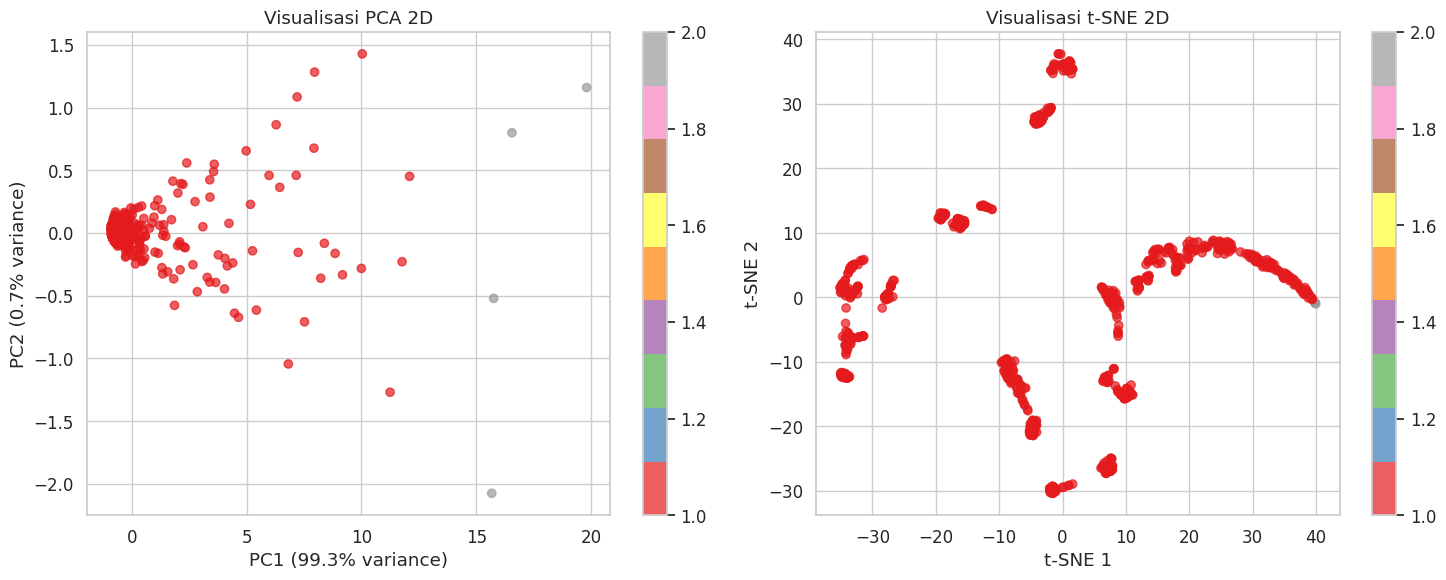

In [ ]:
    if data_standar.shape[1] > 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(data_standar)

        scatter1 = axes[0].scatter(data_pca[:, 0], data_pca[:, 1], c=label_final, cmap='Set1', alpha=0.7)
        axes[0].set_title('Visualisasi PCA 2D')
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.colorbar(scatter1, ax=axes[0])

        perplexity = min(30, len(data_standar)-1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        data_tsne = tsne.fit_transform(data_standar)

        scatter2 = axes[1].scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_final, cmap='Set1', alpha=0.7)
        axes[1].set_title('Visualisasi t-SNE 2D')
        axes[1].set_xlabel('t-SNE 1')
        axes[1].set_ylabel('t-SNE 2')
        plt.colorbar(scatter2, ax=axes[1])

        plt.tight_layout()
        plt.show()

In [ ]:
    print(f"\n--- PROFIL SETIAP CLUSTER ---")
    for i in range(1, k_terbaik + 1):
        print(f"\nCLUSTER {i}")
        cluster_data = data_hasil[data_hasil['Cluster'] == i].drop('Cluster', axis=1)

        print(f"Jumlah wilayah: {len(cluster_data)}")

        rata_rata = cluster_data.mean().sort_values(ascending=False)
        print("Top 5 jenis bencana (rata-rata):")
        for j, (bencana, nilai) in enumerate(rata_rata.head(5).items(), 1):
            print(f"  {j}. {bencana}: {nilai:.2f}")

        print("Wilayah dalam cluster:")
        wilayah_list = cluster_data.index.tolist()
        if len(wilayah_list) <= 10:
            for wilayah in wilayah_list:
                print(f"  - {wilayah}")
        else:
            for wilayah in wilayah_list[:5]:
                print(f"  - {wilayah}")
            print(f"  ... dan {len(wilayah_list)-5} wilayah lainnya")


--- PROFIL SETIAP CLUSTER ---

CLUSTER 1
Jumlah wilayah: 663
Top 5 jenis bencana (rata-rata):
  1. ID_Desa: 20131037218.23
  2. ID_Kec: 20131037.18
  3. pkey: 1045021.90
  4. ID_Kab: 20130.70
  5. ID_Prov: 198.15
Wilayah dalam cluster:
  - Abang
  - Adipala
  - Alak
  - Alalak
  - Alian
  ... dan 658 wilayah lainnya

CLUSTER 2
Jumlah wilayah: 4
Top 5 jenis bencana (rata-rata):
  1. ID_Desa: 426879685439.00
  2. ID_Kec: 426879685.00
  3. pkey: 20631815.50
  4. ID_Kab: 426872.50
  5. ID_Prov: 4169.50
Wilayah dalam cluster:
  - Cakung
  - Cengkareng
  - Kebon Jeruk
  - Kelapa Gading


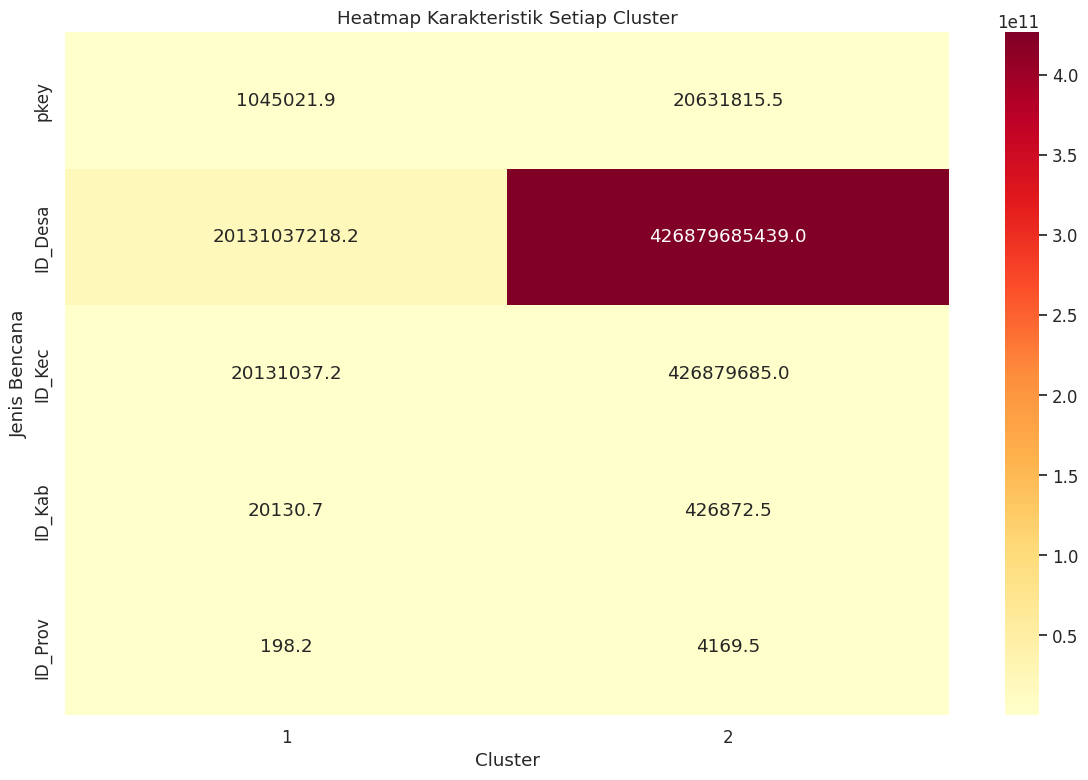

In [ ]:
    plt.figure(figsize=(12, 8))
    cluster_means = data_hasil.groupby('Cluster').mean()
    sns.heatmap(cluster_means.T, annot=True, cmap='YlOrRd', fmt='.1f')
    plt.title('Heatmap Karakteristik Setiap Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Jenis Bencana')
    plt.tight_layout()
    plt.show()

In [ ]:
    print(f"\n=== RINGKASAN HASIL ===")
    print(f"Dataset: {len(data_agregat)} wilayah, {len(kolom_bencana)} jenis bencana")
    print(f"Metode terbaik: {metode_terbaik} linkage")
    print(f"Jumlah cluster optimal: {k_terbaik}")
    print(f"Silhouette Score: {terbaik['Silhouette_Score']:.4f}")
    print(f"Davies-Bouldin Score: {terbaik['Davies_Bouldin_Score']:.4f}")

    print(f"\nINTERPRETASI:")
    if terbaik['Silhouette_Score'] > 0.5:
        print("- Kualitas clustering: BAIK")
    elif terbaik['Silhouette_Score'] > 0.25:
        print("- Kualitas clustering: SEDANG")
    else:
        print("- Kualitas clustering: LEMAH")

    print(f"\nCluster yang terbentuk mencerminkan pola kerawanan bencana yang berbeda")
    print(f"di setiap wilayah, yang dapat digunakan untuk:")
    print(f"• Strategi mitigasi bencana yang tepat sasaran")
    print(f"• Alokasi sumber daya penanganan bencana")
    print(f"• Perencanaan sistem peringatan dini")
    print(f"• Pengembangan infrastruktur tahan bencana")

    print(f"\n=== ANALISIS SELESAI ===")


=== RINGKASAN HASIL ===
Dataset: 667 wilayah, 5 jenis bencana
Metode terbaik: single linkage
Jumlah cluster optimal: 2
Silhouette Score: 0.9124
Davies-Bouldin Score: 0.1706

INTERPRETASI:
- Kualitas clustering: BAIK

Cluster yang terbentuk mencerminkan pola kerawanan bencana yang berbeda
di setiap wilayah, yang dapat digunakan untuk:
• Strategi mitigasi bencana yang tepat sasaran
• Alokasi sumber daya penanganan bencana
• Perencanaan sistem peringatan dini
• Pengembangan infrastruktur tahan bencana

=== ANALISIS SELESAI ===
